In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from model_fit_predict import model_fit_predict

from sklearn.decomposition import PCA
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, precision_recall_fscore_support

In [2]:
plt.style.use("ggplot")
plt.rcParams['figure.figsize'] = (12, 10)

In [3]:
import warnings
warnings.filterwarnings('ignore')

## Part 1: Running Models
### Use Random Forest, Adaboost and XGBoost on the ‘Breast Cancer’ dataset to predict a diagnosis:

In [4]:
cancer = pd.read_csv("data/data-breast-cancer.csv")
display(cancer.head())

id diagnosis  radius_mean  texture_mean  perimeter_mean  area_mean  \
0    842302         M        17.99         10.38          122.80     1001.0   
1    842517         M        20.57         17.77          132.90     1326.0   
2  84300903         M        19.69         21.25          130.00     1203.0   
3  84348301         M        11.42         20.38           77.58      386.1   
4  84358402         M        20.29         14.34          135.10     1297.0   

   smoothness_mean  compactness_mean  concavity_mean  concave points_mean  \
0          0.11840           0.27760          0.3001              0.14710   
1          0.08474           0.07864          0.0869              0.07017   
2          0.10960           0.15990          0.1974              0.12790   
3          0.14250           0.28390          0.2414              0.10520   
4          0.10030           0.13280          0.1980              0.10430   

      ...       texture_worst  perimeter_worst  area_worst  smoothness_worst  \
0     ...               17.33           184.60      2019.0            0.1622   
1     ...               23.41           158.80      1956.0            0.1238   
2     ...               25.53           152.50      1709.0            0.1444   
3     ...               26.50            98.87       567.7            0.2098   
4     ...               16.67           152.20      1575.0            0.1374   

   compactness_worst  concavity_worst  concave points_worst  symmetry_worst  \
0             0.6656           0.7119                0.2654          0.4601   
1             0.1866           0.2416                0.1860          0.2750   
2             0.4245           0.4504                0.2430          0.3613   
3             0.8663           0.6869                0.2575          0.6638   
4             0.2050           0.4000                0.1625          0.2364   

   fractal_dimension_worst  Unnamed: 32  
0                  0.11890          NaN  
1                  0.08902          NaN  
2                  0.08758          NaN  
3                  0.17300          NaN  
4                  0.07678          NaN  

[5 rows x 33 columns]

### Clean and preprocess data.

In [5]:
cancer = cancer.drop("Unnamed: 32", axis=1)

In [6]:
cancer.columns = [col.replace(' ', '_') for col in cancer.columns]

In [7]:
X = cancer.drop(['diagnosis', 'id'], axis=1)
y = cancer.diagnosis

In [8]:
le_y = LabelEncoder()
y_enc = le_y.fit_transform(y)

In [9]:
cancer_train_test = train_test_split(X, y_enc)
X_train, X_test, y_train, y_test = cancer_train_test

### Run the three models on the data.

In [10]:
from sklearn.ensemble import (RandomForestClassifier as RF,
                              AdaBoostClassifier as AB, 
                              GradientBoostingClassifier as GB)

from sklearn.tree import DecisionTreeClassifier as DT

from xgboost import XGBClassifier as XGB

In [11]:
raw_models = dict()
raw_models['Decision Tree Classifier'] = DT
raw_models['Random Forest Classifier'] = RF
raw_models['AdaBoost Classifier'] = AB
raw_models['Gradient Boosting Classifier'] = GB
raw_models['XGBoost Classifier'] = XGB

In [12]:
def fit_predict_models(model_dict, data_train_test):
    models_ = dict()
    for label, model in model_dict.items():
        models_[label] = model_fit_predict(model, *data_train_test, label=label)
        
#     models = {label: 
#               model_fit_predict(model, *cancer_train_test, label=label) 
#               for label, model in raw_models.items()}

    return models_

In [13]:
models = fit_predict_models(raw_models, cancer_train_test)

Decision Tree Classifier
Number of mislabeled points out of 143 points: 9
AdaBoost Classifier
Number of mislabeled points out of 143 points: 5
Random Forest Classifier
Number of mislabeled points out of 143 points: 7
XGBoost Classifier
Number of mislabeled points out of 143 points: 4
Gradient Boosting Classifier
Number of mislabeled points out of 143 points: 6


### Which model is the best in predicting a diagnosis?

In [43]:
def report_model_performance(model_dict, X_test_, y_test_, target_names=None):
    p_mx, r_mx, f_mx, s_mx = 0, 0, 0, 0
    scores_ = dict()
    
    for label in model_dict.keys():
        preds = model_dict[label].predict(X_test_)
        print(60*'=')
        print(label)
        print(60*'-')
        print(classification_report(y_test_, preds, target_names = target_names))
        p, r, f, s = precision_recall_fscore_support(y_test_, preds)
        
        if np.average(f) > np.average(f_mx) :
            scores_['precision'] = np.average(p)
            scores_['recall'] = np.average(r)
            scores_['fscore'] = np.average(f)
            scores_['support'] = np.average(s)
    
    
    return scores_

In [44]:
perf_models = report_model_performance(models, X_test, y_test, target_names = le_y.classes_)

Decision Tree Classifier
------------------------------------------------------------
             precision    recall  f1-score   support

          B       0.99      0.92      0.95        98
          M       0.85      0.98      0.91        45

avg / total       0.94      0.94      0.94       143

AdaBoost Classifier
------------------------------------------------------------
             precision    recall  f1-score   support

          B       0.96      0.99      0.97        98
          M       0.98      0.91      0.94        45

avg / total       0.97      0.97      0.96       143

Random Forest Classifier
------------------------------------------------------------
             precision    recall  f1-score   support

          B       0.97      0.96      0.96        98
          M       0.91      0.93      0.92        45

avg / total       0.95      0.95      0.95       143

Gradient Boosting Classifier
------------------------------------------------------------
            

### What are the top 3 features for each model?

In [16]:
def report_important_features(model_dict, feature_names, n_features=3):
    important_features = set()
    for label in model_dict.keys():
        print(60*'=')
        print(label)
        print(60*'-')
        importances = model_dict[label].feature_importances_
        for val in sorted(importances, reverse=True)[:3]:
            index = np.where(importances == val)[0][0]
            print("{:.4e}".format(val), "\t"+feature_names[index])
            important_features.add(feature_names[index])
            
    return important_features

In [17]:
important = report_important_features(models, X.columns)

Decision Tree Classifier
------------------------------------------------------------
7.2989e-01 	perimeter_worst
8.8521e-02 	concave_points_mean
5.5014e-02 	concave_points_worst
AdaBoost Classifier
------------------------------------------------------------
1.2000e-01 	smoothness_worst
8.0000e-02 	area_se
6.0000e-02 	compactness_mean
Random Forest Classifier
------------------------------------------------------------
2.5180e-01 	radius_worst
1.8082e-01 	perimeter_worst
1.2505e-01 	area_mean
Gradient Boosting Classifier
------------------------------------------------------------
1.4285e-01 	perimeter_worst
1.0699e-01 	radius_worst
7.9419e-02 	concave_points_worst
XGBoost Classifier
------------------------------------------------------------
1.1369e-01 	texture_mean
1.1369e-01 	texture_mean
8.1206e-02 	concave_points_worst


---

## Part 2: Feature Selection
### Are there any features that can be removed (or added)? (Hint: Look at feature correlations)

In [77]:
import seaborn as sns

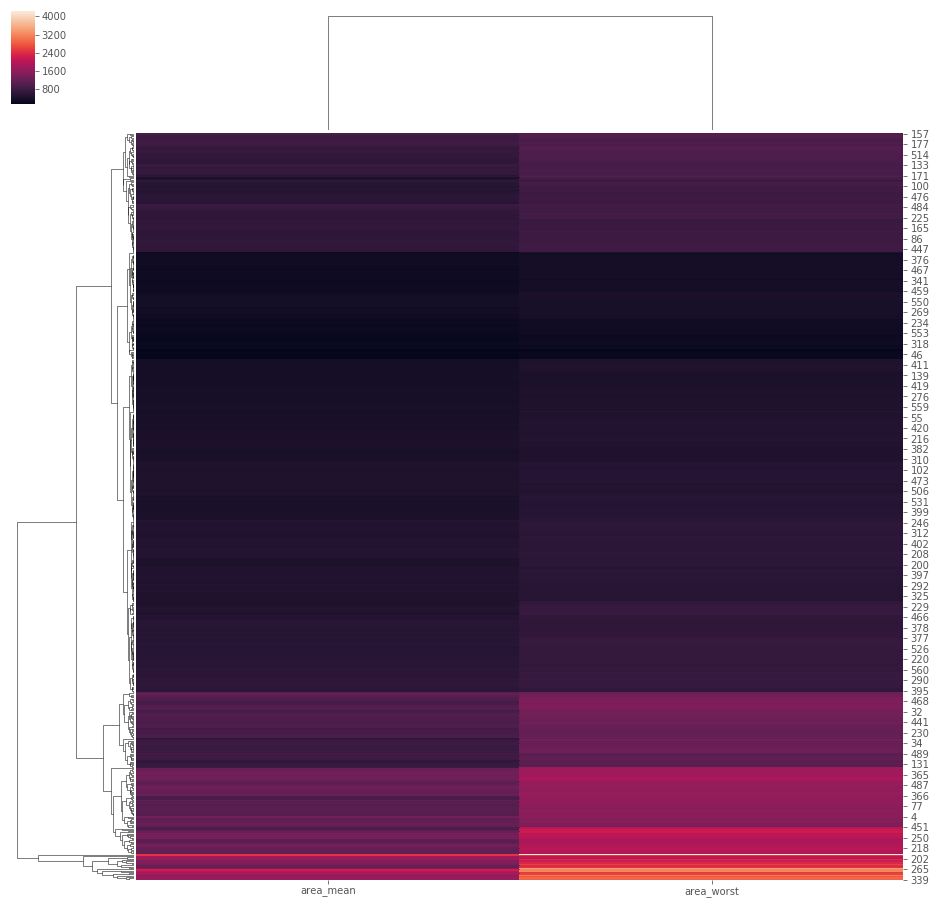

In [92]:
g = sns.clustermap(figsize=(16,16), data=X[['area_mean', 'area_worst']])

In [18]:
def plot_correlation_matrix(df):
    fig = plt.figure()
    ax = fig.add_subplot(111)

    mat = ax.matshow(df.corr(), cmap=plt.cm.RdBu)

    fig.colorbar(mat)

    ticks = range(len(df.columns))
    ax.set_xticks(ticks)
    ax.set_xticklabels(df.columns, 
                       rotation=50, 
                       horizontalalignment = 'left', 
                       verticalalignment='bottom')

    ax.set_yticks(ticks)
    ax.set_yticklabels(df.columns, 
                       rotation=0, 
                       horizontalalignment = 'right', 
                       verticalalignment='bottom')
    None

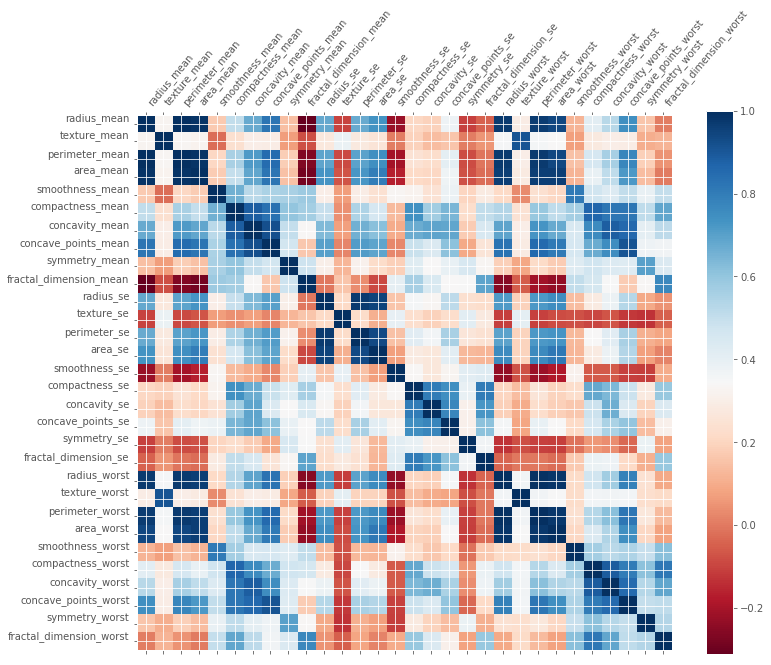

In [19]:
plot_correlation_matrix(X)

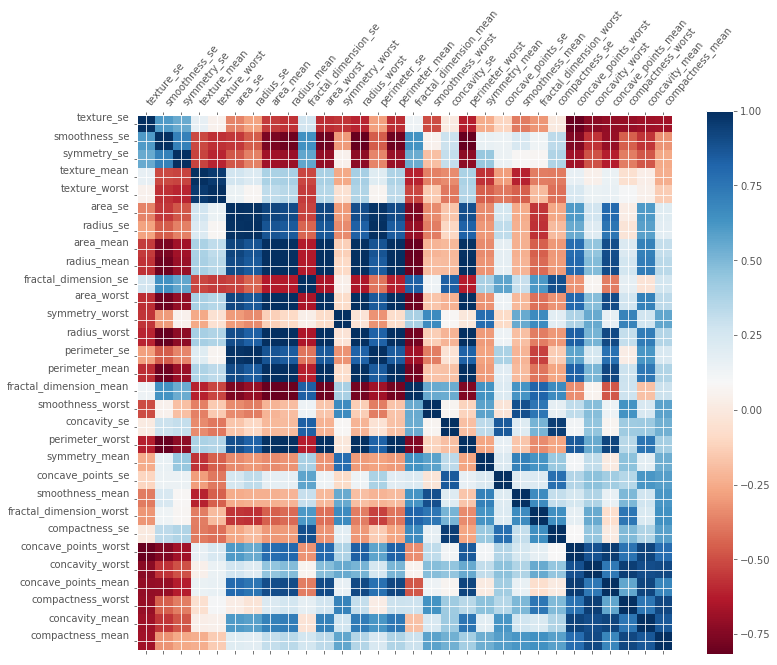

In [20]:
plot_correlation_matrix(X.corr()
                        .sort_values(["compactness_mean", "concavity_mean", "symmetry_mean"])
                        .sort_values(["compactness_mean", "concavity_mean", "symmetry_mean"], axis=1),)

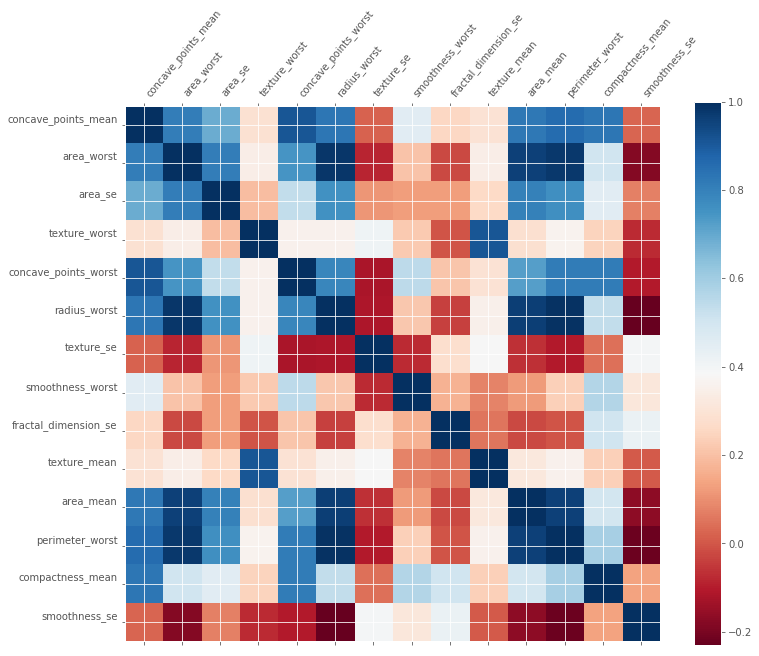

In [106]:
selected = [
#             'fractal_dimension_mean',
            'fractal_dimension_se',
            'smoothness_se',
#             'symmetry_worst',
            'area_worst',
            'texture_se',
#             'texture_mean',
            'texture_worst',
#             'compactness_worst', 
            'concave_points_worst'
        ]

important_selected = list(set(selected + list(important)))

plot_correlation_matrix(X.loc[:, important_selected])

In [108]:
X_selected = X.loc[:, important_selected]
selected_train_test = train_test_split(X_selected, y_enc)
X_train_sel, X_test_sel, y_train_sel, y_test_sel = selected_train_test

updated_models = fit_predict_models(raw_models, selected_train_test)

Decision Tree Classifier
Number of mislabeled points out of 143 points: 11
AdaBoost Classifier
Number of mislabeled points out of 143 points: 4
Random Forest Classifier
Number of mislabeled points out of 143 points: 5
XGBoost Classifier
Number of mislabeled points out of 143 points: 4
Gradient Boosting Classifier
Number of mislabeled points out of 143 points: 5


In [109]:
perf_updated = report_model_performance(updated_models, X_test_sel, y_test_sel)

Decision Tree Classifier
------------------------------------------------------------
             precision    recall  f1-score   support

          0       0.98      0.91      0.94        95
          1       0.84      0.96      0.89        48

avg / total       0.93      0.92      0.92       143

AdaBoost Classifier
------------------------------------------------------------
             precision    recall  f1-score   support

          0       0.99      0.97      0.98        95
          1       0.94      0.98      0.96        48

avg / total       0.97      0.97      0.97       143

Random Forest Classifier
------------------------------------------------------------
             precision    recall  f1-score   support

          0       0.98      0.97      0.97        95
          1       0.94      0.96      0.95        48

avg / total       0.97      0.97      0.97       143

Gradient Boosting Classifier
------------------------------------------------------------
            

#### Use PCA to reduce dimensionality

Which features are significant components in PCA?

In [110]:
n = 1
ratio = 0
while ratio < .9999 and n <= len(X.columns):
    ratio = sum(PCA(n_components = n).fit(X).explained_variance_ratio_)
    print("Explained Variance with {} features: {:.2f}%".format(n, 100*ratio))
    n += 1
n -= 1

Explained Variance with 1 features: 98.20%
Explained Variance with 2 features: 99.82%
Explained Variance with 3 features: 99.98%
Explained Variance with 4 features: 99.99%
Explained Variance with 5 features: 100.00%


In [111]:
pca = PCA(n)
pca.fit(X)

PCA(copy=True, iterated_power='auto', n_components=5, random_state=None,
  svd_solver='auto', tol=0.0, whiten=False)

In [112]:
X_trans = pca.transform(X)

In [116]:
pca_train_test = train_test_split(X_trans, y_enc)
X_train_pca, X_test_pca, y_train_pca, y_test_pca = pca_train_test

### Run the three models again, and compare results from part 1.

In [117]:
pca_models = fit_predict_models(raw_models, pca_train_test)

Decision Tree Classifier
Number of mislabeled points out of 143 points: 8
AdaBoost Classifier
Number of mislabeled points out of 143 points: 6
Random Forest Classifier
Number of mislabeled points out of 143 points: 7
XGBoost Classifier
Number of mislabeled points out of 143 points: 8
Gradient Boosting Classifier
Number of mislabeled points out of 143 points: 8


In [118]:
perf_pca = report_model_performance(pca_models, X_test_pca, y_test_pca)

Decision Tree Classifier
------------------------------------------------------------
             precision    recall  f1-score   support

          0       0.96      0.96      0.96        91
          1       0.92      0.92      0.92        52

avg / total       0.94      0.94      0.94       143

AdaBoost Classifier
------------------------------------------------------------
             precision    recall  f1-score   support

          0       0.95      0.99      0.97        91
          1       0.98      0.90      0.94        52

avg / total       0.96      0.96      0.96       143

Random Forest Classifier
------------------------------------------------------------
             precision    recall  f1-score   support

          0       0.95      0.98      0.96        91
          1       0.96      0.90      0.93        52

avg / total       0.95      0.95      0.95       143

Gradient Boosting Classifier
------------------------------------------------------------
            

In [119]:
print("Difference in PCA vs. manually selecting features")
for key in perf_pca.keys():
    print("{}: \t{:.4e}".format(key, perf_pca[key] - perf_updated[key]))


Difference in PCA vs. manually selecting features
support: 	0.0000e+00
fscore: 	-3.0146e-02
recall: 	-3.7322e-02
precision: 	-2.1053e-02


In [120]:
print("Difference in PCA vs. no feature selection")
for key in perf_pca.keys():
    print("{}: \t{:.4e}".format(key, perf_pca[key] - perf_models[key]))


Difference in PCA vs. no feature selection
support: 	0.0000e+00
fscore: 	-2.9457e-02
recall: 	-4.2264e-02
precision: 	-1.5289e-02


---

## Part 3: Hyperparameter Tuning
### Using GridSearch and Random Search, tune the hyperparameters of the three models:

In [123]:
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV

In [124]:
list(models.keys())

['Decision Tree Classifier',
 'AdaBoost Classifier',
 'Random Forest Classifier',
 'Gradient Boosting Classifier',
 'XGBoost Classifier']

In [125]:
r_f = models['Random Forest Classifier']

In [140]:
# http://scikit-learn.org/stable/auto_examples/model_selection/plot_randomized_search.html#sphx-glr-auto-examples-model-selection-plot-randomized-search-py
from scipy.stats import randint as sp_randint

param_dist = {"max_depth": [3, None],
              "max_features": sp_randint(1, 11),
              "min_samples_split": sp_randint(2, 11),
              "min_samples_leaf": sp_randint(1, 11),
              "bootstrap": [True, False],
              "criterion": ["gini", "entropy"]}

rand_RF = RandomizedSearchCV(r_f, param_dist)

In [133]:
# http://scikit-learn.org/stable/auto_examples/model_selection/plot_randomized_search.html#sphx-glr-auto-examples-model-selection-plot-randomized-search-py
# Utility function to report best scores
def report(results, n_top=3):
    for i in range(1, n_top + 1):
        candidates = np.flatnonzero(results['rank_test_score'] == i)
        for candidate in candidates:
            print("Model with rank: {0}".format(i))
            print("Mean validation score: {0:.3f} (std: {1:.3f})".format(
                  results['mean_test_score'][candidate],
                  results['std_test_score'][candidate]))
            print("Parameters: {0}".format(results['params'][candidate]))
            print("")

### Run both GridSearch and Random Search for all three models.

In [132]:
%timeit rand_RF.fit(X,y)

1.19 s ± 118 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


In [134]:
report(rand_RF.cv_results_)

Model with rank: 1
Mean validation score: 0.963 (std: 0.011)
Parameters: {'min_samples_split': 8, 'max_features': 7, 'bootstrap': False, 'min_samples_leaf': 6, 'criterion': 'entropy', 'max_depth': None}

Model with rank: 2
Mean validation score: 0.958 (std: 0.023)
Parameters: {'min_samples_split': 4, 'max_features': 6, 'bootstrap': True, 'min_samples_leaf': 10, 'criterion': 'entropy', 'max_depth': None}

Model with rank: 3
Mean validation score: 0.954 (std: 0.009)
Parameters: {'min_samples_split': 9, 'max_features': 9, 'bootstrap': False, 'min_samples_leaf': 4, 'criterion': 'entropy', 'max_depth': None}



In [151]:
models['Decision Tree Classifier'].get_params()

{'class_weight': None,
 'criterion': 'gini',
 'max_depth': None,
 'max_features': None,
 'max_leaf_nodes': None,
 'min_impurity_decrease': 0.0,
 'min_impurity_split': None,
 'min_samples_leaf': 1,
 'min_samples_split': 2,
 'min_weight_fraction_leaf': 0.0,
 'presort': False,
 'random_state': None,
 'splitter': 'best'}

In [152]:
# for label in models.keys():
#     rand_cv = RandomizedSearchCV(models[label], models[label].get_params())
#     print('-'*60)
#     print(label)
#     %timeit rand_cv.fit(X,y)
#     report(rand_cv.cv_results_)
#     print('.'*60)

### Compare with previous results in part 1 and 2.